In [1]:
import pandas as pd
import scipy.io as sio
from scipy.io import savemat, loadmat
from EEG_pareidolia_utils import get_pareidolia_bids, reformat_events
from biotuner_utils import *
from biotuner_offline import *
from biotuner import *
import pyACA
import mne
from mne.datasets.brainstorm import bst_raw
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio
import seaborn as sbn

In [2]:
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 20],[20, 30], [30, 45], [45, 60]]
par = ['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low']
nopar = ['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low']
frontal_L = ['E20', 'E21', 'E22', 'E23', 'E24', 'E26', 'E27', 'E12', 'E18', 'E19', 'E11', 'E15', 'E16']
frontal_R = ['E2', 'E3', 'E4', 'E5', 'E118', 'E124', 'E123', 'E9', 'E10', 'E14', 'E11', 'E15', 'E16']
frontal_LR = frontal_L+frontal_R
occi_R = ['E76', 'E83', 'E84']
occi_L = ['E66', 'E70', 'E71']

In [3]:
def renormalize(n, range1, range2):
    delta1 = range1[1] - range1[0]
    delta2 = range2[1] - range2[0]
    return (delta2 * (n - range1[0]) / delta1) + range2[0]
def dissmeasure(fvec, amp, model='min'):
    """
    Given a list of partials in fvec, with amplitudes in amp, this routine
    calculates the dissonance by summing the roughness of every sine pair
    based on a model of Plomp-Levelt's roughness curve.
    The older model (model='product') was based on the product of the two
    amplitudes, but the newer model (model='min') is based on the minimum
    of the two amplitudes, since this matches the beat frequency amplitude.
    """
    # Sort by frequency
    sort_idx = np.argsort(fvec)
    am_sorted = np.asarray(amp)[sort_idx]
    fr_sorted = np.asarray(fvec)[sort_idx]

    # Used to stretch dissonance curve for different freqs:
    Dstar = 0.24  # Point of maximum dissonance
    S1 = 0.0207
    S2 = 18.96

    C1 = 5
    C2 = -5

    # Plomp-Levelt roughness curve:
    A1 = -3.51
    A2 = -5.75

    # Generate all combinations of frequency components
    idx = np.transpose(np.triu_indices(len(fr_sorted), 1))
    fr_pairs = fr_sorted[idx]
    am_pairs = am_sorted[idx]

    Fmin = fr_pairs[:, 0]
    S = Dstar / (S1 * Fmin + S2)
    Fdif = fr_pairs[:, 1] - fr_pairs[:, 0]

    if model == 'min':
        a = np.amin(am_pairs, axis=1)
    elif model == 'product':
        a = np.prod(am_pairs, axis=1)  # Older model
    else:
        raise ValueError('model should be "min" or "product"')
    SFdif = S * Fdif
    D = np.sum(a * (C1 * np.exp(A1 * SFdif) + C2 * np.exp(A2 * SFdif)))

    return D


In [902]:
def compute_peaks_avg(epochs, condition, chs, FREQ_BANDS, dim_reduc = 'avg', tmin = None, tmax = None, precision = 0.125, sf = 1000):
    import functools
    import pandas as pd
    from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
    #epochs are cropped as desire (tmin could be before '0', ex: -1.5, depending on the values used during epoching)
    epochs = epochs.apply_baseline((-1.5, -0.1))
    epochs = epochs.crop(tmin, tmax)
    print(epochs.get_data().shape)
    EOG_chs = ['E1', 'E8', 'E25', 'E32', 'E126', 'E127']
    Unwanted = ['E43', 'E48', 'E49', 'E128', 'E113', 'E120', 'E125', 'E119', 'E129']
    All_chs = epochs.info['ch_names'][0:129]
    EEG_chs = [ele for ele in All_chs if ele not in Unwanted]
    EEG_chs = [ele for ele in EEG_chs if ele not in EOG_chs]
    #Find number of samples
    n_samples = len(epochs.get_data()[0][0])-1
    #print(n_samples)
    precision = precision/(sf/n_samples)
    fft_size = int(n_samples/precision)
    #print(fft_size)
    #Average across trials for specific condition
    evoked = epochs[condition].average(chs)
    FREQs_temp2 = []
    #This loop iterates for each epoch
    amp_temp2 = []
    for min, max in FREQ_BANDS:
        FREQs_temp = []
        amp_temp = []
        #psds, freqs = function(epochs[t], fmin=min, fmax=max, bandwidth = 4, picks = EEG_chs)  #PSDs are calculated with this function, giving power values and corresponding frequency bins as output
        psds, freqs = psd_welch(evoked, fmin=min, fmax=max, n_fft = fft_size)
        psds = 10. * np.log10(psds)   #PSDs values are transformed in log scale to compensate for the 1/f natural slope
        for ch in range(len(psds)):
            index_max = np.argmax(np.array(psds[ch][:]))
            freq = freqs[index_max]
            #print(psds.shape)
            amp_temp.append(psds[ch][index_max])
            print(index_max) # Should not be zero in all bands (would signify strong 1/f trend)
            FREQs_temp.append(freq)
        if dim_reduc =='avg':
            FREQs_avg = np.average(FREQs_temp)
            FREQs_temp2.append(FREQs_avg)
            amp_avg = np.average(amp_temp)
            amp_temp2.append(amp_avg)
        if dim_reduc =='mode':
            s = pd.Series(FREQs_temp)
            FREQs_mode = s[s.duplicated()].unique().tolist()
            import itertools

            FREQs_temp2.append(FREQs_mode)
            print(FREQs_temp2)
        if dim_reduc ==None:
            FREQs_temp2.append(FREQs_temp)
    if dim_reduc =='avg':
        FREQs_temp2 = [round(num, 1) for num in FREQs_temp2]
    elif dim_reduc =='mode':
        FREQs_temp2 = list(itertools.chain(*FREQs_temp2))
    FREQs = np.array(FREQs_temp2)
    amplitudes = np.array(amp_temp2)
    return FREQs, amplitudes

def diss_curve (freqs, amps, denom=10, max_ratio=2):
    from numpy import array, linspace, empty, concatenate
    from scipy.signal import argrelextrema
    from fractions import Fraction
    freqs = np.array(freqs)
    r_low = 1
    alpharange = max_ratio
    method = 'product'

    n = 1000
    diss = empty(n)
    a = concatenate((amps, amps))
    for i, alpha in enumerate(linspace(r_low, alpharange, n)):
        f = concatenate((freqs, alpha*freqs))
        d = dissmeasure(f, a, method)
        diss[i] = d

    plt.figure(figsize=(7, 3))
    plt.plot(linspace(r_low, alpharange, len(diss)), diss)
    plt.xscale('log')
    plt.xlim(r_low, alpharange)

    plt.xlabel('frequency ratio')
    plt.ylabel('sensory dissonance')


    diss_minima = argrelextrema(diss, np.less)
    print(diss_minima)
    intervals = []
    for d in range(len(diss_minima[0])):
        
        frac = Fraction(diss_minima[0][d]/(n/(max_ratio-1))+1).limit_denominator(denom)
        frac = (frac.numerator, frac.denominator)
        intervals.append(frac)

    
    intervals.append((2, 1))
    ratios = [i[0]/i[1] for i in intervals]
    for n, d in intervals:
        plt.axvline(n/d, color='silver')

    #plt.yticks([])
    plt.minorticks_off()
    plt.xticks([n/d for n, d in intervals],
               ['{}/{}'.format(n, d) for n, d in intervals])
    plt.tight_layout()
    plt.show()
    return intervals, ratios

In [837]:
def compute_peaks_raw(eeg_data, FREQ_BANDS, sf=1000, nperseg = 0, nfft = 0):
    if nperseg == 0:
        nperseg = sf*4
        nfft = sf*4
    import scipy
    psd_all = []
    freqs_all = []
    FREQs_temp= []
    amp_temp = []
    #print(nperseg)
    for minf, maxf in FREQ_BANDS:
        freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg)
        psd = 10. * np.log10(psd) 
        bin_size = (sf/2)/len(freqs)
        min_index = int(minf/bin_size)
        max_index = int(maxf/bin_size)
        index_max = np.argmax(np.array(psd[min_index:max_index]))
        print(index_max)
        #print('min:', freqs[min_index])
        #print('max:', freqs[max_index])
         #   print(index_max) # Should not be zero in all bands (would signify strong 1/f trend)
        FREQs_temp.append(freqs[min_index+index_max])
        amp_temp.append(psd[min_index+index_max])

    FREQS = np.array(FREQs_temp)
    amps = np.array(amp_temp)
    return FREQS, amps

In [368]:
def intersect_with_threshold(lst1, lst2, threshold):
    intersected_list=[]
    lst2 = sorted(lst2)
    i = 0
    for j in sorted(lst1):
        lower = j - threshold
        try:
            while not lower < lst2[i]:
                i += 1
        except IndexError:
            break
        if lst2[i] < j + threshold:
            intersected_list.append(j)
    return list(set(intersected_list))

In [868]:
def diss_curve_multi (freqs, amps, denom=10, max_ratio=2, bound = 10, n_cons_chs = 2):
    from numpy import array, linspace, empty, concatenate
    from scipy.signal import argrelextrema
    from fractions import Fraction
    import matplotlib.lines as mlines
    color_nocons = 'red'
    plt.figure(figsize=(16, 9))
    diss_minima_tot = []
    diss_tot = []
    for fr, am in zip(freqs, amps):
        freqs = np.array(fr)
        r_low = 1
        alpharange = max_ratio
        method = 'product'

        n = 1000
        diss = empty(n)
        a = concatenate((am, am))
        for i, alpha in enumerate(linspace(r_low, alpharange, n)):
            f = concatenate((freqs, alpha*freqs))
            d = dissmeasure(f, a, method)
            diss[i] = d

        diss_tot.append(diss)
        


        diss_minima = argrelextrema(diss, np.less)
        diss_minima_tot.append(list(diss_minima[0]))
        #print(diss_minima)
    
    diss_tot_flat = [item for sublist in diss_minima_tot for item in sublist]
    diss_tot_flat.sort()
    new_minima = []
    
    for i in range(len(diss_tot_flat)-1):
        if (diss_tot_flat[i+1] - diss_tot_flat[i]) < bound:
            new_minima.append((diss_tot_flat[i]+diss_tot_flat[i+1])/2)
    #print(new_minima)
    
    ch_list = []
    minima_cons = []
    ch_single_cons = []
    for ch in range(len(diss_minima_tot)):
        if len(intersect_with_threshold(diss_minima_tot[ch],new_minima, bound)) >= n_cons_chs:
            minima_cons.append(intersect_with_threshold(diss_minima_tot[ch],new_minima, bound))
            ch_list.append(ch)
        if len(intersect_with_threshold(diss_minima_tot[ch],new_minima, bound)) >= 2 and ch not in ch_list:
            ch_single_cons.append(ch)
            
    minima_cons = [item for sublist in minima_cons for item in sublist]
    minima_cons = list(set(minima_cons))
    minima_cons.sort()
    print(minima_cons)
    minima_final = []
    for i in range(len(minima_cons)-1):
        if (minima_cons[i+1] - minima_cons[i]) < bound:
            
            minima_cons[i] = (minima_cons[i]+minima_cons[i+1])/2
            minima_cons[i+1] = minima_cons[i]
            #minima_final.append((minima_cons[i]+minima_cons[i+1])/2)
    
    
    print(ch_single_cons)
    print(ch_list)
    for i in range(len(diss_tot)):
        if i in ch_list:
            black, = plt.plot(linspace(r_low, alpharange, len(diss_tot[i])), diss_tot[i], color = 'black')
            
        #if i in ch_single_cons:
        #    plt.plot(linspace(r_low, alpharange, len(diss_tot[i])), diss_tot[i], color = 'navy', linestyle = 'dotted')
        #if i not in ch_list and i not in ch_single_cons:
        #    plt.plot(linspace(r_low, alpharange, len(diss_tot[i])), diss_tot[i], color = color_nocons, linestyle = 'dotted')
            
        plt.xscale('log')
        plt.xlim(r_low, alpharange)

        plt.xlabel('frequency ratio', fontsize = 16)
        plt.ylabel('sensory dissonance', fontsize = 16)
        
    intervals = []
    minima_float = []
    for d in range(len(minima_cons)):
        #print(new_minima[d])
        frac = Fraction(minima_cons[d]/(n/(max_ratio-1))+1).limit_denominator(denom)
        print(frac)
        frac = (frac.numerator, frac.denominator)
        intervals.append(frac)
        minima_float.append(minima_cons[d]/(n/(max_ratio-1))+1)
    
    #intervals = [(123, 100), (147, 100), (159, 100), (9, 5), (2, 1)]
    intervals.append((2, 1))
    print(intervals)
    for n, d in intervals:
        plt.axvline(n/d, color='silver')

    #plt.yticks([])
    plt.minorticks_off()
    plt.xticks([n/d for n, d in intervals],
               ['{}/{}'.format(n, d) for n, d in intervals], fontsize = 12)
    

    black_line = mlines.Line2D([], [], color='black',
                           label='More than '+ str(n_cons_chs)+' consonant peaks', markersize = 14)
    no_cons_line = mlines.Line2D([], [], color=color_nocons,
                           label='Less than 2 consonant peaks', markersize = 14, linestyle = 'dotted')
    plt.yticks(fontsize = 12)
    plt.legend(handles = [black_line, no_cons_line])
    plt.tight_layout()
    plt.show()
    return intervals, minima_float

## Compute peaks and amplitudes from EEG spectrum

In [281]:
epochs = mne.read_epochs('../../pareidolia_run2.fif')
#epochs = mne.read_epochs('C:/Users/Antoine/github/Data_EEG/pareidolia_run1.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading ../../pareidolia_run2.fif ...


<ipython-input-281-66f92cd7d033>:1: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('../../pareidolia_run2.fif')


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


<EpochsFIF  |   104 events (all good), 0.5 - 7.5 sec, baseline [-1.5, -0.1], ~72.3 MB, data loaded,
 'Image_on_nopar_high': 24
 'Image_on_nopar_low': 12
 'Image_on_nopar_mid': 10
 'Image_on_par_high': 16
 'Image_on_par_low': 20
 'Image_on_par_mid': 22>

In [224]:
eeg_data[]

104

In [877]:
chs = frontal_L
EOG_chs = ['E1', 'E8', 'E25', 'E32', 'E126', 'E127']
Unwanted = ['E43', 'E48', 'E49', 'E128', 'E113', 'E120', 'E125', 'E119', 'E129']
All_chs = epochs.info['ch_names'][0:129]
EEG_chs = [ele for ele in All_chs if ele not in Unwanted]
EEG_chs = [ele for ele in EEG_chs if ele not in EOG_chs]
epochs_temp = epochs.copy().pick_channels(EEG_chs)
epochs_crop = epochs_temp.crop(0.5, 7.5)
eeg_data = epochs_crop.get_data()
eeg_data.shape


#for trial in range(11):
eeg_trial = eeg_data[34, :, :]
peaks_tot = []
amps_tot = []
print(eeg_trial.shape)
for ch in range(len(eeg_trial)):
    eeg_temp = eeg_trial[ch, :]
    peaks_raw, amps = compute_peaks_raw(eeg_temp, FREQ_BANDS)
    peaks_tot.append([int(np.round(p*128)) for p in peaks_raw])
    amps = [(float(i)-min(amp))/(max(amp)-min(amp)) for i in amp]
    amps = np.interp(amp, (amp.min(), amp.max()), (0.4, 0.6))
    amps_tot.append(amps)

(114, 7001)
7
1
5
0
0
5
55
7
1
0
0
16
54
18
3
11
0
15
20
55
26
3
11
0
4
11
14
28
3
11
0
4
8
9
14
0
11
0
5
8
9
53
7
2
4
10
33
20
27
3
2
10
23
27
0
57
3
11
0
15
29
37
33
3
11
0
4
23
9
14
0
11
0
5
8
9
53
6
2
8
11
25
19
48
7
2
10
11
36
25
49
3
11
10
15
10
0
1
7
1
10
11
39
15
58
3
2
10
15
27
1
43
2
11
0
4
27
9
11
0
11
9
5
27
9
53
5
2
10
22
35
1
33
5
2
10
11
7
1
53
0
2
0
23
31
1
27
0
11
10
4
27
1
53
0
2
7
24
27
1
57
0
2
7
23
27
1
39
0
11
10
5
27
12
39
0
11
10
5
27
8
5
0
12
0
5
0
0
35
0
14
0
5
0
0
9
0
2
7
23
29
1
46
1
2
7
23
27
12
53
0
14
10
5
27
17
50
0
14
10
5
6
0
36
5
14
10
0
0
0
3
0
2
7
23
27
14
3
5
2
7
0
27
14
3
5
14
7
0
15
7
13
6
14
10
0
36
7
50
5
14
10
0
6
7
3
5
2
7
0
15
14
3
5
14
7
0
20
13
3
5
14
4
0
37
7
3
5
14
4
0
6
7
3
0
14
4
3
10
10
3
5
14
4
3
37
17
3
5
14
11
3
10
7
3
6
14
11
0
10
7
3
3
14
10
0
14
7
3
3
11
0
1
4
8
15
5
2
4
3
12
9
38
5
14
4
3
15
14
3
6
14
5
3
10
17
3
5
14
11
3
10
17
3
5
14
11
0
15
17
3
6
11
5
0
13
10
2
3
11
5
0
24
17
22
6
11
5
14
15
1
3
6
11
11
2
10
17
3
6
11
11
1


[181, 192, 198, 199, 263, 270, 273, 307, 335, 345, 351, 382, 422, 434, 441, 461, 500, 512, 522, 536, 651, 661, 695, 698, 764, 845, 849, 878, 904, 925, 946, 950, 951, 957, 961]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
[46, 51, 55, 97]
13/11
31/26
6/5
6/5
24/19
47/37
14/11
17/13
4/3
39/29
50/37
47/34
64/45
43/30
49/34
19/13
3/2
62/41
35/23
43/28
71/43
78/47
61/36
73/43
30/17
83/45
61/33
77/41
40/21
77/40
72/37
39/20
39/20
92/47
51/26
[(13, 11), (31, 26), (6, 5), (6, 5), (24, 19), (47, 37), (14, 11), (17, 13), (4, 3), (39, 29), (50, 37), (47, 34), (64, 45), (43, 30), (49, 34), (19, 13), (3, 2

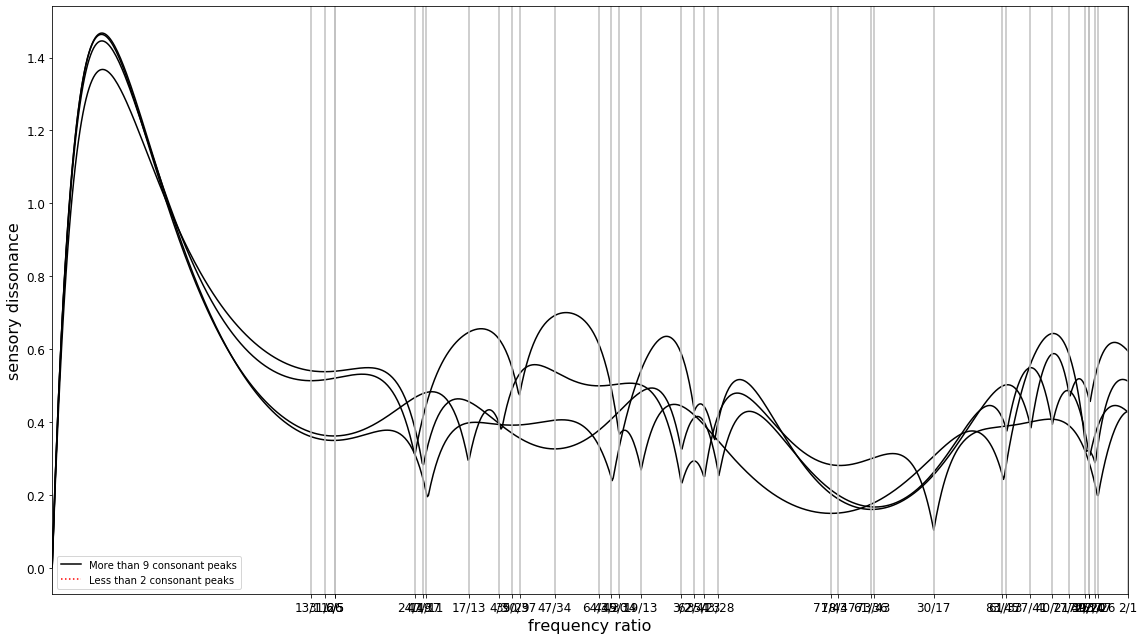

In [879]:
intervals, minima_float = diss_curve_multi(peaks_tot, amps_tot, 48, 2, 2, 10)

In [876]:
length = 1000
chord = make_chord(300, minima_float[3:8])

chord = np.ascontiguousarray(np.vstack([chord,chord]).T)


sound = pygame.sndarray.make_sound(chord)
sound.play(loops=0, maxtime=0, fade_ms=0)
pygame.time.wait(int(sound.get_length() * length))

1000

minima_float

In [711]:
n = 1000
n_chs_cons = 3
diss_tot

ch_list = []
for ch in range(len(diss_tot)):
    if len(list(set(diss_tot[ch]).intersection(new_minima))) != 0:
        ch_list.append(ch)
ch_list            

[0, 1, 2]

(114, 7001)
7
1
5
0
0
5
55
(array([182, 347, 454, 562, 666, 793, 879], dtype=int64),)


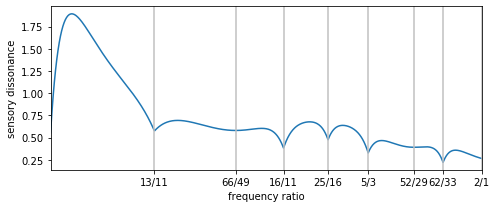

[1.1818181818181819, 1.346938775510204, 1.4545454545454546, 1.5625, 1.6666666666666667, 1.793103448275862, 1.878787878787879, 2.0]
7
1
0
0
16
54
18
(array([138, 182, 500, 714, 812, 878], dtype=int64),)


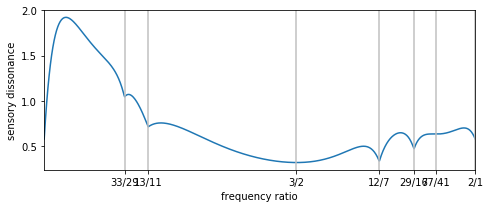

[1.1379310344827587, 1.1818181818181819, 1.5, 1.7142857142857142, 1.8125, 1.8780487804878048, 2.0]
3
11
0
15
20
55
26
(array([177, 217, 441, 587, 749, 897], dtype=int64),)


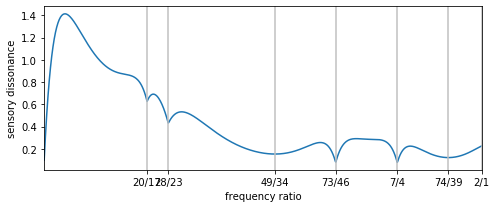

[1.1764705882352942, 1.2173913043478262, 1.4411764705882353, 1.5869565217391304, 1.75, 1.8974358974358974, 2.0]
3
11
0
4
11
14
28
(array([217, 375, 472, 552, 636, 749, 856], dtype=int64),)


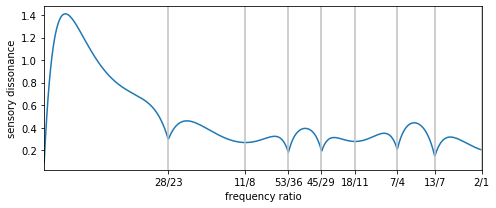

[1.2173913043478262, 1.375, 1.4722222222222223, 1.5517241379310345, 1.6363636363636365, 1.75, 1.8571428571428572, 2.0]
3
11
0
4
8
9
14
(array([217, 364, 465, 503, 604, 692, 856], dtype=int64),)


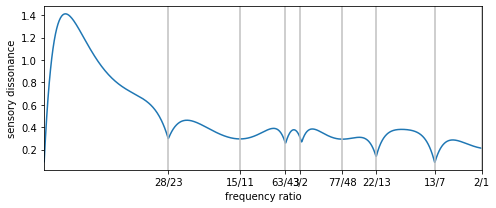

[1.2173913043478262, 1.3636363636363635, 1.4651162790697674, 1.5, 1.6041666666666667, 1.6923076923076923, 1.8571428571428572, 2.0]
0
11
0
5
8
9
53
(array([217, 381, 465, 564, 660, 805, 892], dtype=int64),)


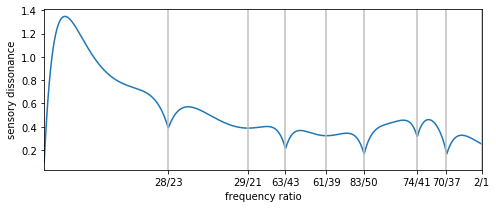

[1.2173913043478262, 1.380952380952381, 1.4651162790697674, 1.564102564102564, 1.66, 1.8048780487804879, 1.8918918918918919, 2.0]
7
2
4
10
33
20
27
(array([239, 273, 409, 478, 618, 812, 831, 947], dtype=int64),)


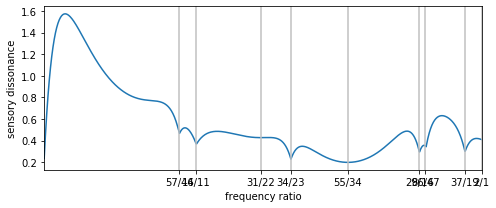

[1.2391304347826086, 1.2727272727272727, 1.4090909090909092, 1.4782608695652173, 1.6176470588235294, 1.8125, 1.8297872340425532, 1.9473684210526316, 2.0]
3
2
10
23
27
0
57
(array([122, 357, 507, 581, 689, 868, 974], dtype=int64),)


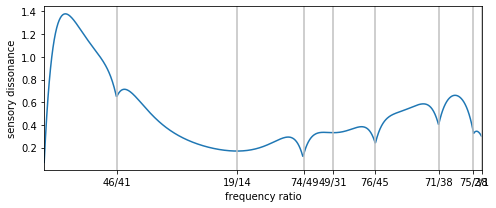

[1.1219512195121952, 1.3571428571428572, 1.510204081632653, 1.5806451612903225, 1.6888888888888889, 1.868421052631579, 1.9736842105263157, 2.0]
3
11
0
15
29
37
33
(array([217, 356, 440, 581, 729, 845, 953], dtype=int64),)


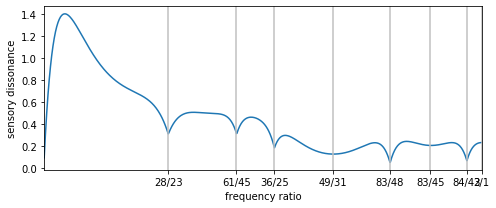

[1.2173913043478262, 1.3555555555555556, 1.44, 1.5806451612903225, 1.7291666666666667, 1.8444444444444446, 1.9534883720930232, 2.0]
3
11
0
4
23
9
14
(array([217, 252, 413, 503, 639, 856, 882, 980], dtype=int64),)


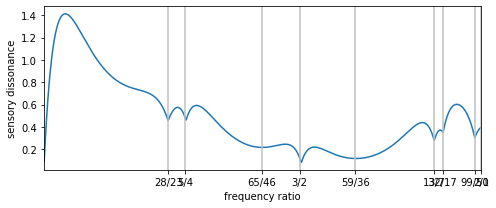

[1.2173913043478262, 1.25, 1.4130434782608696, 1.5, 1.6388888888888888, 1.8571428571428572, 1.8823529411764706, 1.98, 2.0]
0
11
0
5
8
9
53
(array([217, 381, 465, 564, 660, 805, 892], dtype=int64),)


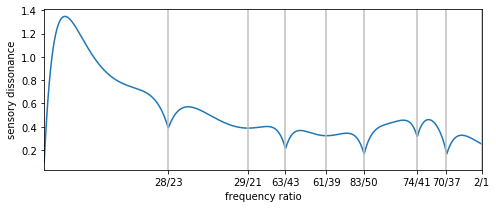

[1.2173913043478262, 1.380952380952381, 1.4651162790697674, 1.564102564102564, 1.66, 1.8048780487804879, 1.8918918918918919, 2.0]
6
2
8
11
25
19
48
(array([216, 324, 400, 639, 779, 981], dtype=int64),)


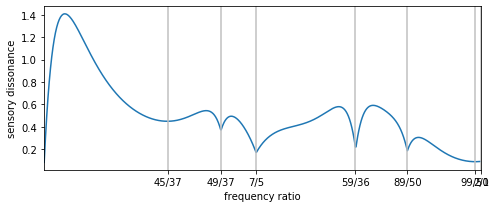

[1.2162162162162162, 1.3243243243243243, 1.4, 1.6388888888888888, 1.78, 1.98, 2.0]
7
2
10
11
36
25
49
(array([250, 272, 421, 552, 579, 768, 965, 973], dtype=int64),)


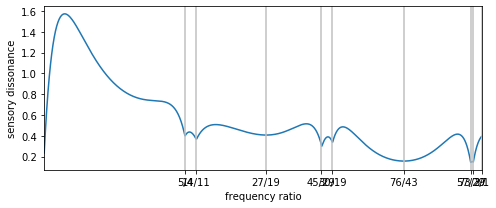

[1.25, 1.2727272727272727, 1.4210526315789473, 1.5517241379310345, 1.5789473684210527, 1.7674418604651163, 1.9655172413793103, 1.972972972972973, 2.0]
3
11
10
15
10
0
1
(array([234, 333, 428, 508, 657, 828, 904], dtype=int64),)


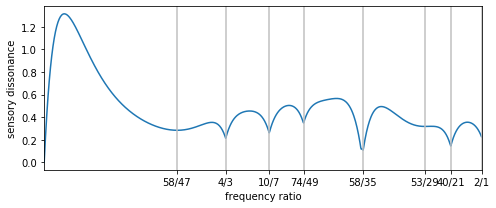

[1.2340425531914894, 1.3333333333333333, 1.4285714285714286, 1.510204081632653, 1.6571428571428573, 1.8275862068965518, 1.9047619047619047, 2.0]
7
1
10
11
39
15
58
(array([135, 182, 413, 552, 679, 762, 850], dtype=int64),)


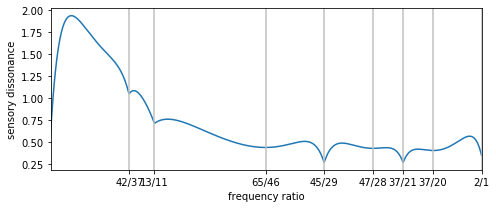

[1.135135135135135, 1.1818181818181819, 1.4130434782608696, 1.5517241379310345, 1.6785714285714286, 1.7619047619047619, 1.85, 2.0]
3
2
10
15
27
1
43
(array([131, 419, 657, 698, 842, 920], dtype=int64),)


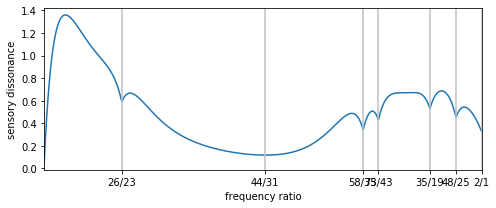

[1.1304347826086956, 1.4193548387096775, 1.6571428571428573, 1.697674418604651, 1.8421052631578947, 1.92, 2.0]
2
11
0
4
27
9
11
(array([206, 217, 397, 480, 613, 784, 856], dtype=int64),)


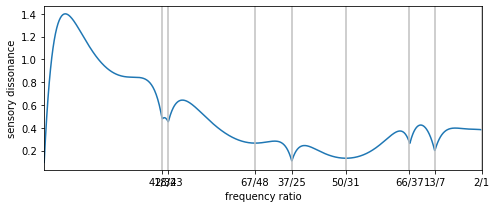

[1.2058823529411764, 1.2173913043478262, 1.3958333333333333, 1.48, 1.6129032258064515, 1.7837837837837838, 1.8571428571428572, 2.0]
0
11
9
5
27
9
53
(array([205, 315, 432, 608, 805, 904], dtype=int64),)


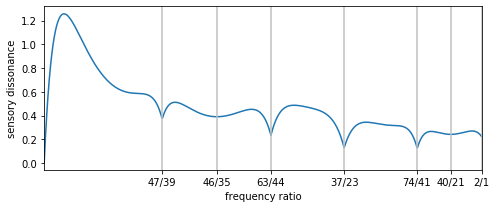

[1.205128205128205, 1.3142857142857143, 1.4318181818181819, 1.608695652173913, 1.8048780487804879, 1.9047619047619047, 2.0]
5
2
10
22
35
1
33
(array([ 52, 310, 555, 642, 728, 759, 842, 851], dtype=int64),)


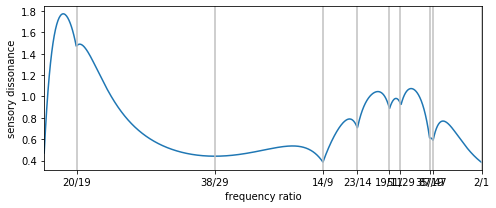

[1.0526315789473684, 1.3103448275862069, 1.5555555555555556, 1.6428571428571428, 1.7272727272727273, 1.7586206896551724, 1.8421052631578947, 1.851063829787234, 2.0]
5
2
10
11
7
1
53
(array([256, 390, 474, 552, 799, 925], dtype=int64),)


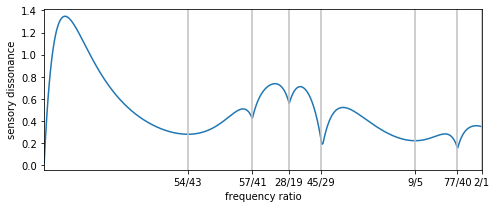

[1.255813953488372, 1.3902439024390243, 1.4736842105263157, 1.5517241379310345, 1.8, 1.925, 2.0]
0
2
0
23
31
1
27
(array([ 90, 410, 563, 704, 710, 864], dtype=int64),)


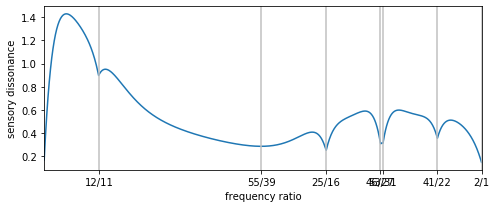

[1.0909090909090908, 1.4102564102564104, 1.5625, 1.7037037037037037, 1.7096774193548387, 1.8636363636363635, 2.0]
0
11
10
4
27
1
53
(array([131, 253, 368, 516, 652, 807, 925], dtype=int64),)


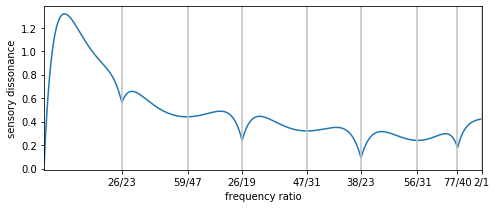

[1.1304347826086956, 1.2553191489361701, 1.368421052631579, 1.5161290322580645, 1.6521739130434783, 1.8064516129032258, 1.925, 2.0]
0
2
7
24
27
1
57
(array([131, 353, 486, 595, 680, 812, 958], dtype=int64),)


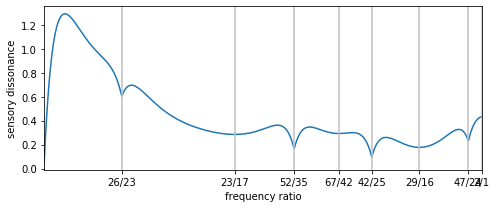

[1.1304347826086956, 1.3529411764705883, 1.4857142857142858, 1.5952380952380953, 1.68, 1.8125, 1.9583333333333333, 2.0]
0
2
7
23
27
1
39
(array([131, 369, 507, 608, 703, 809, 882], dtype=int64),)


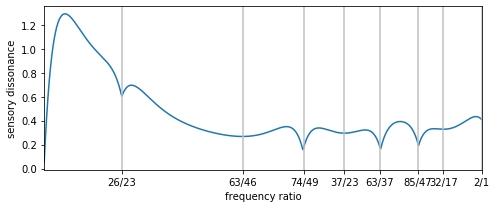

[1.1304347826086956, 1.3695652173913044, 1.510204081632653, 1.608695652173913, 1.7027027027027026, 1.8085106382978724, 1.8823529411764706, 2.0]
0
11
10
5
27
12
39
(array([164, 233, 394, 512, 652, 658, 849], dtype=int64),)


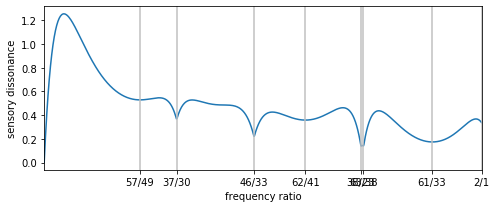

[1.163265306122449, 1.2333333333333334, 1.393939393939394, 1.5121951219512195, 1.6521739130434783, 1.6578947368421053, 1.8484848484848484, 2.0]
0
11
10
5
27
8
5
(array([196, 289, 394, 445, 565, 651, 728, 884], dtype=int64),)


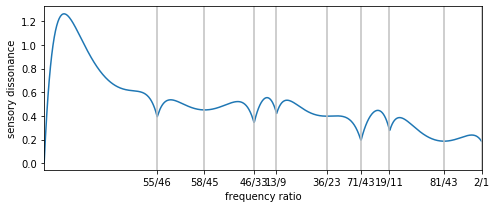

[1.1956521739130435, 1.288888888888889, 1.393939393939394, 1.4444444444444444, 1.565217391304348, 1.6511627906976745, 1.7272727272727273, 1.8837209302325582, 2.0]
0
12
0
5
0
0
35
(array([167, 359, 500, 509, 665, 791, 892], dtype=int64),)


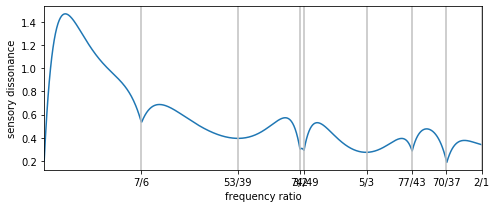

[1.1666666666666667, 1.358974358974359, 1.5, 1.510204081632653, 1.6666666666666667, 1.7906976744186047, 1.8918918918918919, 2.0]
0
14
0
5
0
0
9
(array([ 77, 340, 500, 509, 575, 721, 892], dtype=int64),)


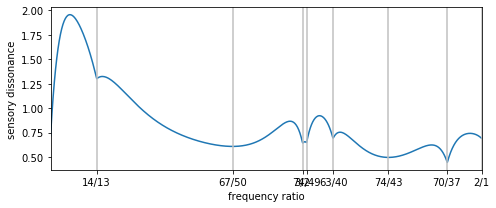

[1.0769230769230769, 1.34, 1.5, 1.510204081632653, 1.575, 1.7209302325581395, 1.8918918918918919, 2.0]
0
2
7
23
29
1
46
(array([110, 390, 535, 704, 778, 867], dtype=int64),)


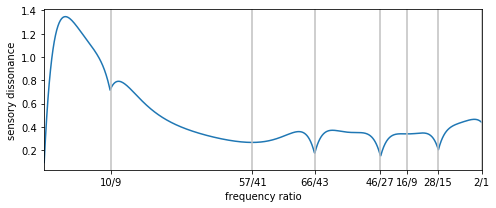

[1.1111111111111112, 1.3902439024390243, 1.5348837209302326, 1.7037037037037037, 1.7777777777777777, 1.8666666666666667, 2.0]
1
2
7
23
27
12
53
(array([233, 384, 507, 638, 764, 858], dtype=int64),)


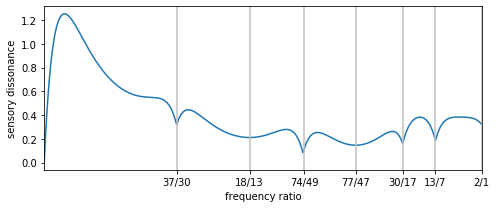

[1.2333333333333334, 1.3846153846153846, 1.510204081632653, 1.6382978723404256, 1.7647058823529411, 1.8571428571428572, 2.0]
0
14
10
5
27
17
50
(array([181, 280, 394, 461, 678, 808], dtype=int64),)


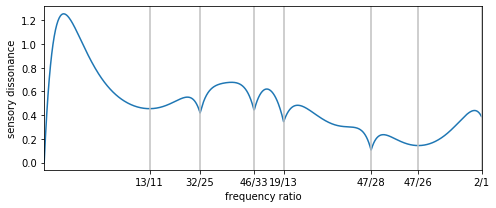

[1.1818181818181819, 1.28, 1.393939393939394, 1.4615384615384615, 1.6785714285714286, 1.8076923076923077, 2.0]
0
14
10
5
6
0
36
(array([219, 395, 461, 622, 799, 902], dtype=int64),)


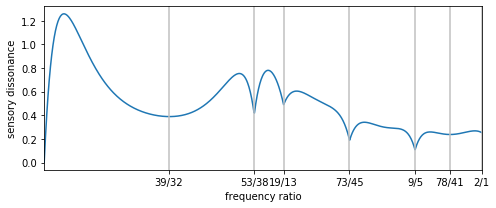

[1.21875, 1.394736842105263, 1.4615384615384615, 1.6222222222222222, 1.8, 1.9024390243902438, 2.0]
5
14
10
0
0
0
3
(array([199, 263, 348, 461, 499, 524, 666, 845, 967], dtype=int64),)


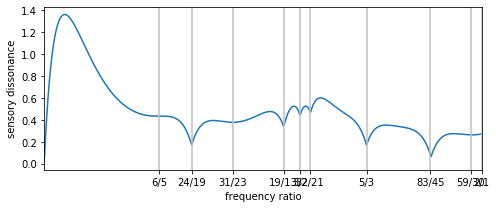

[1.2, 1.263157894736842, 1.3478260869565217, 1.4615384615384615, 1.5, 1.5238095238095237, 1.6666666666666667, 1.8444444444444446, 1.9666666666666666, 2.0]
0
2
7
23
27
14
3
(array([180, 252, 365, 507, 620, 710, 886], dtype=int64),)


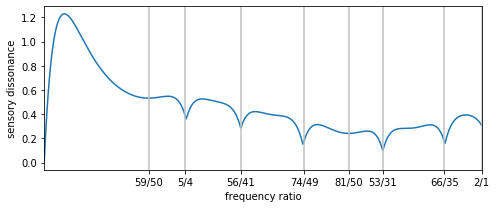

[1.18, 1.25, 1.3658536585365855, 1.510204081632653, 1.62, 1.7096774193548387, 1.8857142857142857, 2.0]
5
2
7
0
27
14
3
(array([185, 252, 366, 371, 555, 710, 976], dtype=int64),)


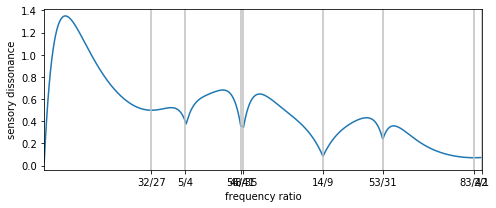

[1.1851851851851851, 1.25, 1.3658536585365855, 1.3714285714285714, 1.5555555555555556, 1.7096774193548387, 1.9761904761904763, 2.0]
5
14
7
0
15
7
13
(array([197, 337, 346, 371, 519, 657, 845, 978], dtype=int64),)


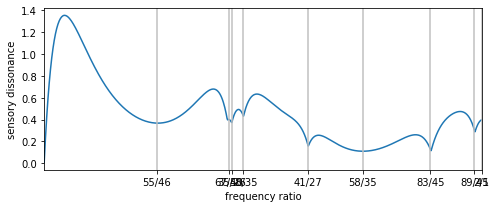

[1.1956521739130435, 1.34, 1.3461538461538463, 1.3714285714285714, 1.5185185185185186, 1.6571428571428573, 1.8444444444444446, 1.9777777777777779, 2.0]
6
14
10
0
36
7
50
(array([ 95, 263, 461, 634, 810, 845, 982], dtype=int64),)


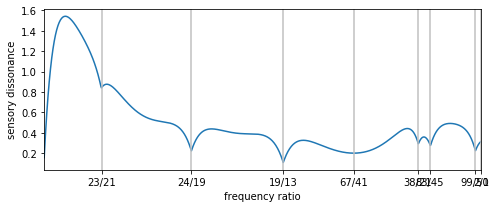

[1.0952380952380953, 1.263157894736842, 1.4615384615384615, 1.6341463414634145, 1.8095238095238095, 1.8444444444444446, 1.98, 2.0]
5
14
10
0
6
7
3
(array([196, 263, 441, 461, 476, 638, 791, 845], dtype=int64),)


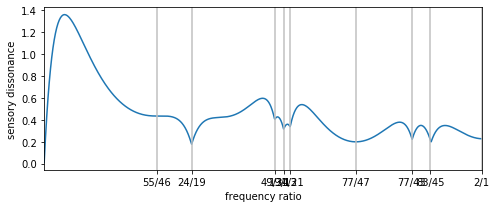

[1.1956521739130435, 1.263157894736842, 1.4411764705882353, 1.4615384615384615, 1.4761904761904763, 1.6382978723404256, 1.7906976744186047, 1.8444444444444446, 2.0]
5
2
7
0
15
14
3
(array([223, 366, 371, 410, 555, 765, 925, 978], dtype=int64),)


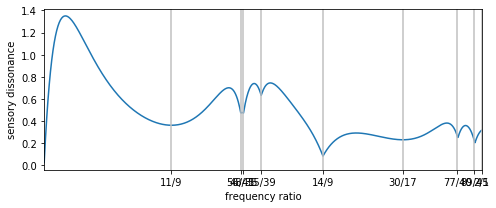

[1.2222222222222223, 1.3658536585365855, 1.3714285714285714, 1.4102564102564104, 1.5555555555555556, 1.7647058823529411, 1.925, 1.9777777777777779, 2.0]
5
14
7
0
20
13
3
(array([194, 330, 346, 371, 608, 829, 845], dtype=int64),)


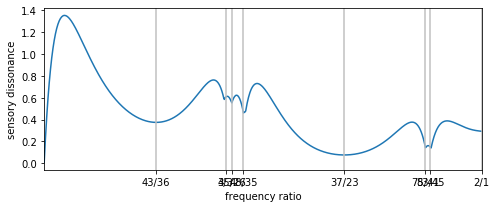

[1.1944444444444444, 1.3333333333333333, 1.3461538461538463, 1.3714285714285714, 1.608695652173913, 1.829268292682927, 1.8444444444444446, 2.0]
5
14
4
0
37
7
3
(array([ 86, 231, 342, 440, 500, 564, 704, 845], dtype=int64),)


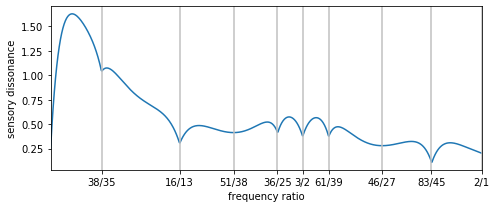

[1.0857142857142856, 1.2307692307692308, 1.3421052631578947, 1.44, 1.5, 1.564102564102564, 1.7037037037037037, 1.8444444444444446, 2.0]
5
14
4
0
6
7
3
(array([231, 332, 440, 476, 499, 646, 791, 845], dtype=int64),)


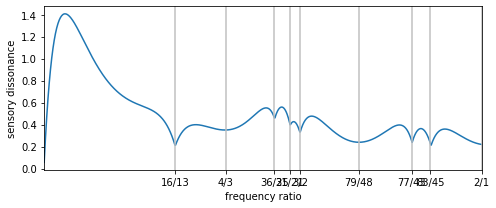

[1.2307692307692308, 1.3333333333333333, 1.44, 1.4761904761904763, 1.5, 1.6458333333333333, 1.7906976744186047, 1.8444444444444446, 2.0]
0
14
4
3
10
10
3
(array([231, 325, 407, 444, 593, 764, 854, 961], dtype=int64),)


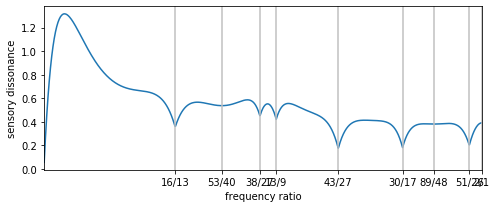

[1.2307692307692308, 1.325, 1.4074074074074074, 1.4444444444444444, 1.5925925925925926, 1.7647058823529411, 1.8541666666666667, 1.9615384615384615, 2.0]
5
14
4
3
37
17
3
(array([171, 231, 336, 436, 564, 593, 778, 961], dtype=int64),)


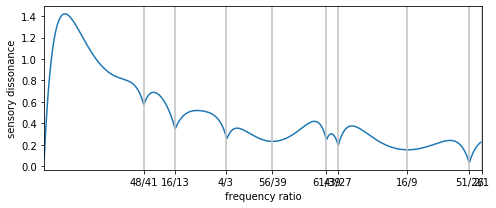

[1.170731707317073, 1.2307692307692308, 1.3333333333333333, 1.435897435897436, 1.564102564102564, 1.5925925925925926, 1.7777777777777777, 1.9615384615384615, 2.0]
5
14
11
3
10
7
3
(array([205, 307, 411, 441, 500, 647, 764, 961], dtype=int64),)


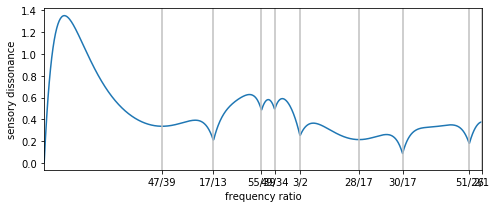

[1.205128205128205, 1.3076923076923077, 1.4102564102564104, 1.4411764705882353, 1.5, 1.6470588235294117, 1.7647058823529411, 1.9615384615384615, 2.0]
6
14
11
0
10
7
3
(array([231, 311, 411, 440, 500, 662, 845, 874], dtype=int64),)


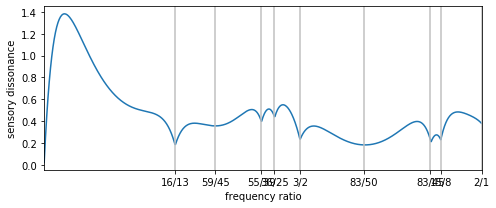

[1.2307692307692308, 1.3111111111111111, 1.4102564102564104, 1.44, 1.5, 1.66, 1.8444444444444446, 1.875, 2.0]
3
14
10
0
14
7
3
(array([182, 263, 351, 441, 461, 655, 845, 946, 957], dtype=int64),)


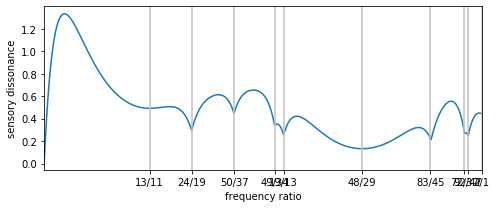

[1.1818181818181819, 1.263157894736842, 1.3513513513513513, 1.4411764705882353, 1.4615384615384615, 1.6551724137931034, 1.8444444444444446, 1.945945945945946, 1.9574468085106382, 2.0]
3
11
0
1
4
8
15
(array([217, 388, 523, 614, 714, 749, 949], dtype=int64),)


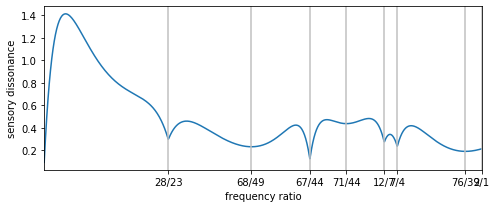

[1.2173913043478262, 1.3877551020408163, 1.5227272727272727, 1.6136363636363635, 1.7142857142857142, 1.75, 1.9487179487179487, 2.0]
5
2
4
3
12
9
38
(array([267, 402, 555, 593, 689, 803], dtype=int64),)


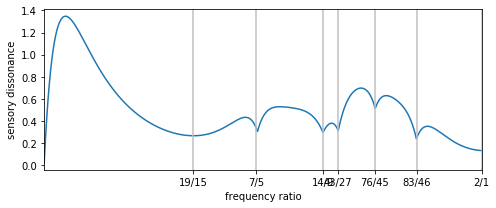

[1.2666666666666666, 1.4, 1.5555555555555556, 1.5925925925925926, 1.6888888888888889, 1.8043478260869565, 2.0]
5
14
4
3
15
14
3
(array([231, 365, 410, 593, 711, 862, 926, 961], dtype=int64),)


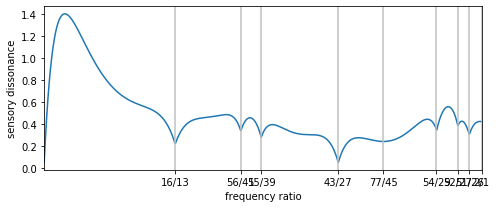

[1.2307692307692308, 1.3658536585365855, 1.4102564102564104, 1.5925925925925926, 1.711111111111111, 1.8620689655172413, 1.9259259259259258, 1.9615384615384615, 2.0]
6
14
5
3
10
17
3
(array([269, 335, 419, 522, 545, 678, 764, 961], dtype=int64),)


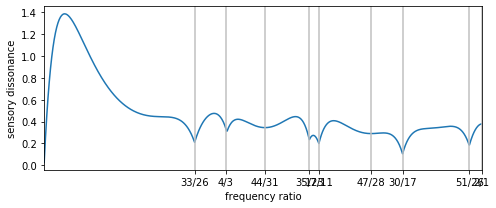

[1.2692307692307692, 1.3333333333333333, 1.4193548387096775, 1.5217391304347827, 1.5454545454545454, 1.6785714285714286, 1.7647058823529411, 1.9615384615384615, 2.0]
5
14
11
3
10
17
3
(array([199, 307, 335, 426, 500, 522, 664, 764, 961], dtype=int64),)


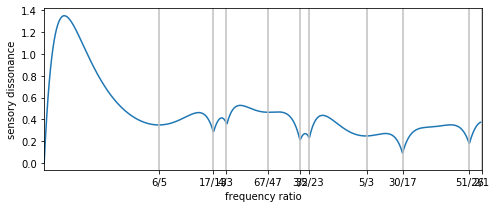

[1.2, 1.3076923076923077, 1.3333333333333333, 1.425531914893617, 1.5, 1.5217391304347827, 1.6666666666666667, 1.7647058823529411, 1.9615384615384615, 2.0]
5
14
11
0
15
17
3
(array([231, 335, 442, 500, 670, 845, 925, 978], dtype=int64),)


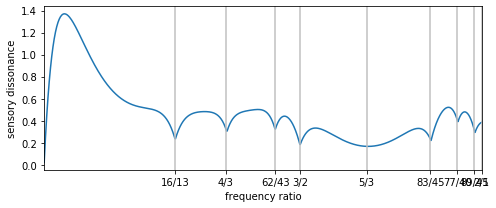

[1.2307692307692308, 1.3333333333333333, 1.441860465116279, 1.5, 1.6666666666666667, 1.8444444444444446, 1.925, 1.9777777777777779, 2.0]
6
11
5
0
13
10
2
(array([235, 399, 435, 454, 704, 937, 956], dtype=int64),)


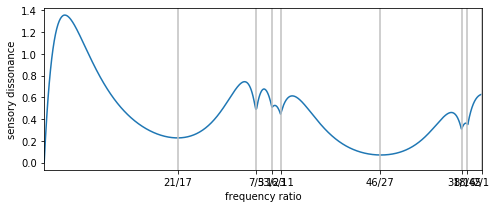

[1.2352941176470589, 1.4, 1.434782608695652, 1.4545454545454546, 1.7037037037037037, 1.9375, 1.9555555555555555, 2.0]
3
11
5
0
24
17
22
(array([215, 317, 435, 454, 474, 735, 941], dtype=int64),)


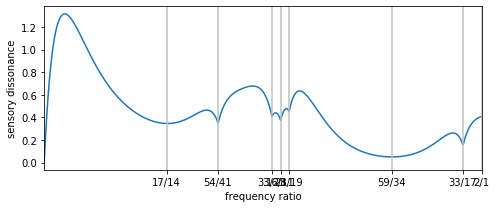

[1.2142857142857142, 1.3170731707317074, 1.434782608695652, 1.4545454545454546, 1.4736842105263157, 1.7352941176470589, 1.9411764705882353, 2.0]
6
11
5
14
15
1
3
(array([201, 273, 345, 434, 512, 532, 694, 878, 925, 951], dtype=int64),)


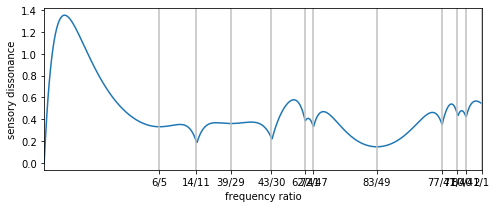

[1.2, 1.2727272727272727, 1.3448275862068966, 1.4333333333333333, 1.5121951219512195, 1.5319148936170213, 1.6938775510204083, 1.8780487804878048, 1.925, 1.951219512195122, 2.0]
6
11
11
2
10
17
3
(array([194, 282, 335, 437, 522, 695, 799, 912], dtype=int64),)


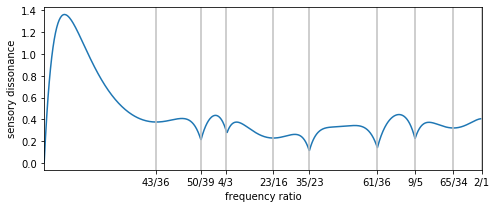

[1.1944444444444444, 1.2820512820512822, 1.3333333333333333, 1.4375, 1.5217391304347827, 1.6944444444444444, 1.8, 1.911764705882353, 2.0]
6
11
11
1
10
17
39
(array([256, 398, 522, 598, 695, 836, 956], dtype=int64),)


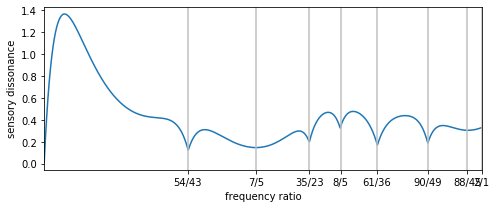

[1.255813953488372, 1.4, 1.5217391304347827, 1.6, 1.6944444444444444, 1.836734693877551, 1.9555555555555555, 2.0]
0
11
11
1
37
17
3
(array([171, 256, 336, 456, 563, 695, 916], dtype=int64),)


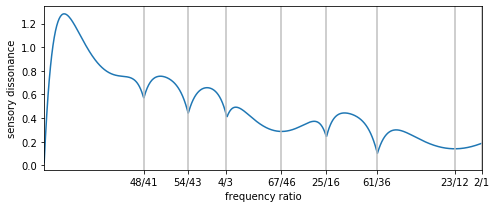

[1.170731707317073, 1.255813953488372, 1.3333333333333333, 1.4565217391304348, 1.5625, 1.6944444444444444, 1.9166666666666667, 2.0]
6
11
5
0
24
17
22
(array([216, 317, 435, 454, 474, 726, 941], dtype=int64),)


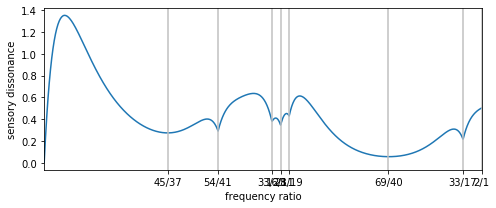

[1.2162162162162162, 1.3170731707317074, 1.434782608695652, 1.4545454545454546, 1.4736842105263157, 1.725, 1.9411764705882353, 2.0]
6
11
5
2
17
17
41
(array([250, 412, 434, 515, 613, 765, 939], dtype=int64),)


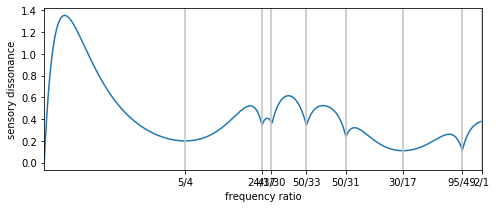

[1.25, 1.411764705882353, 1.4333333333333333, 1.5151515151515151, 1.6129032258064515, 1.7647058823529411, 1.9387755102040816, 2.0]
6
11
11
1
17
17
41
(array([256, 412, 498, 612, 695, 831, 979], dtype=int64),)


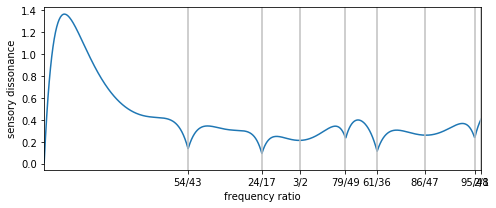

[1.255813953488372, 1.411764705882353, 1.5, 1.6122448979591837, 1.6944444444444444, 1.8297872340425532, 1.9791666666666667, 2.0]
0
11
11
1
24
17
39
(array([162, 256, 317, 467, 598, 695, 882], dtype=int64),)


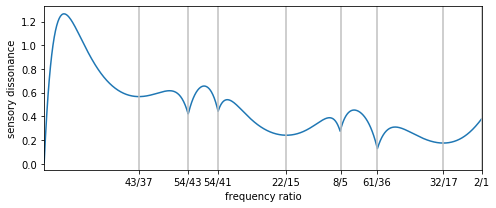

[1.162162162162162, 1.255813953488372, 1.3170731707317074, 1.4666666666666666, 1.6, 1.6944444444444444, 1.8823529411764706, 2.0]
0
12
5
0
24
17
22
(array([192, 317, 375, 454, 474, 721, 941], dtype=int64),)


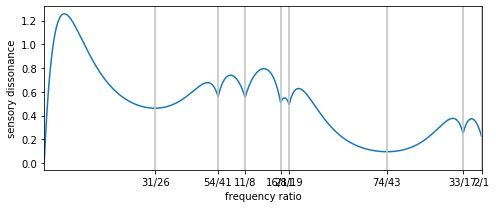

[1.1923076923076923, 1.3170731707317074, 1.375, 1.4545454545454546, 1.4736842105263157, 1.7209302325581395, 1.9411764705882353, 2.0]
0
11
5
0
24
17
22
(array([202, 317, 435, 454, 474, 745, 941], dtype=int64),)


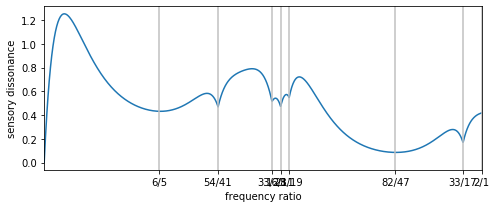

[1.2, 1.3170731707317074, 1.434782608695652, 1.4545454545454546, 1.4736842105263157, 1.7446808510638299, 1.9411764705882353, 2.0]
6
11
11
2
23
17
41
(array([191, 282, 330, 470, 612, 695, 863], dtype=int64),)


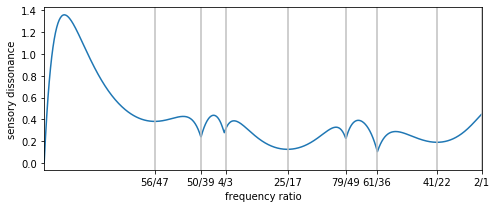

[1.1914893617021276, 1.2820512820512822, 1.3333333333333333, 1.4705882352941178, 1.6122448979591837, 1.6944444444444444, 1.8636363636363635, 2.0]
0
11
11
15
24
17
39
(array([216, 317, 432, 598, 615, 650, 695, 930], dtype=int64),)


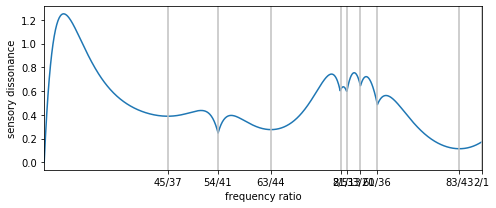

[1.2162162162162162, 1.3170731707317074, 1.4318181818181819, 1.6, 1.6153846153846154, 1.65, 1.6944444444444444, 1.930232558139535, 2.0]
6
11
11
0
24
17
54
(array([231, 317, 472, 695, 707, 882], dtype=int64),)


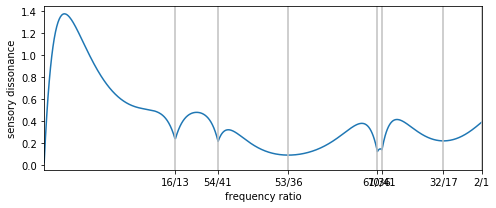

[1.2307692307692308, 1.3170731707317074, 1.4722222222222223, 1.6944444444444444, 1.7073170731707317, 1.8823529411764706, 2.0]
0
11
5
0
38
17
22
(array([161, 271, 435, 454, 474, 711, 869], dtype=int64),)


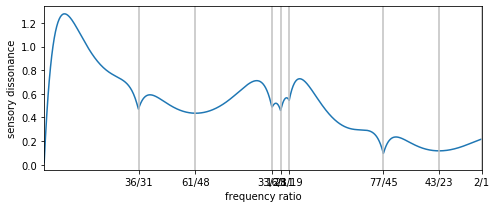

[1.1612903225806452, 1.2708333333333333, 1.434782608695652, 1.4545454545454546, 1.4736842105263157, 1.711111111111111, 1.8695652173913044, 2.0]
2
11
0
0
0
17
25
(array([217, 397, 496, 666, 713, 922], dtype=int64),)


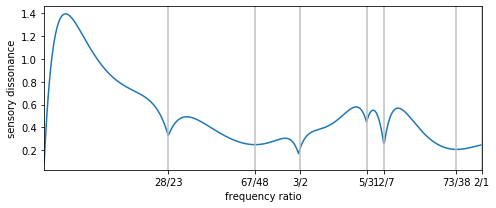

[1.2173913043478262, 1.3958333333333333, 1.5, 1.6666666666666667, 1.7142857142857142, 1.9210526315789473, 2.0]
3
11
1
12
0
0
25
(array([261, 333, 500, 611, 708, 821], dtype=int64),)


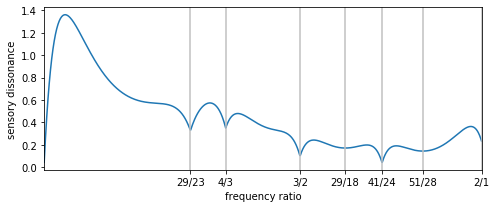

[1.2608695652173914, 1.3333333333333333, 1.5, 1.6111111111111112, 1.7083333333333333, 1.8214285714285714, 2.0]
7
11
1
5
0
0
25
(array([261, 375, 500, 509, 623, 708, 827], dtype=int64),)


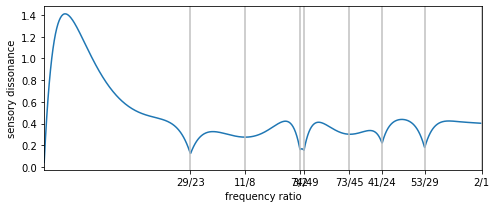

[1.2608695652173914, 1.375, 1.5, 1.510204081632653, 1.6222222222222222, 1.7083333333333333, 1.8275862068965518, 2.0]
3
11
0
10
0
0
25
(array([217, 379, 500, 613, 708, 838], dtype=int64),)


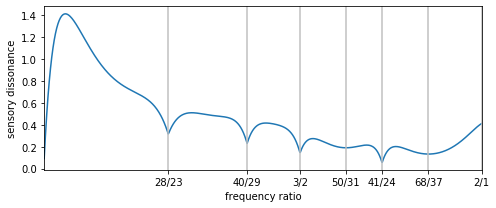

[1.2173913043478262, 1.3793103448275863, 1.5, 1.6129032258064515, 1.7083333333333333, 1.837837837837838, 2.0]
6
11
5
0
24
30
0
(array([200, 282, 442, 454, 639, 730, 857], dtype=int64),)


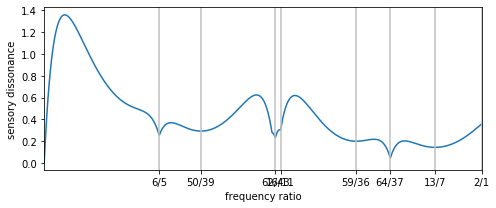

[1.2, 1.2820512820512822, 1.441860465116279, 1.4545454545454546, 1.6388888888888888, 1.7297297297297298, 1.8571428571428572, 2.0]
6
11
5
0
24
17
54
(array([216, 317, 435, 454, 627, 707, 841], dtype=int64),)


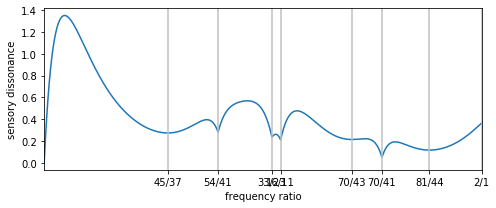

[1.2162162162162162, 1.3170731707317074, 1.434782608695652, 1.4545454545454546, 1.627906976744186, 1.7073170731707317, 1.8409090909090908, 2.0]
0
11
5
0
38
17
44
(array([161, 273, 435, 454, 634, 766, 897], dtype=int64),)


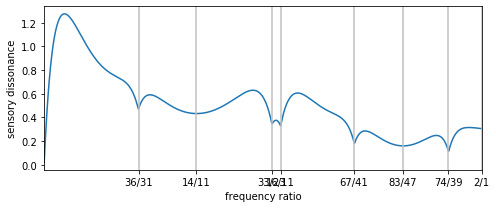

[1.1612903225806452, 1.2727272727272727, 1.434782608695652, 1.4545454545454546, 1.6341463414634145, 1.7659574468085106, 1.8974358974358974, 2.0]
2
11
5
0
24
17
25
(array([213, 317, 435, 454, 496, 748, 970], dtype=int64),)


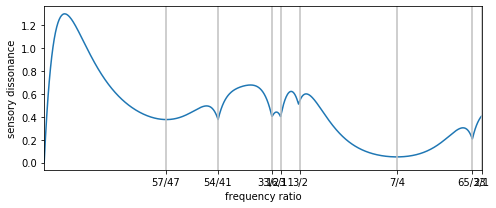

[1.2127659574468086, 1.3170731707317074, 1.434782608695652, 1.4545454545454546, 1.5, 1.75, 1.9696969696969697, 2.0]
6
11
1
5
0
0
25
(array([261, 376, 500, 509, 626, 708, 827, 989], dtype=int64),)


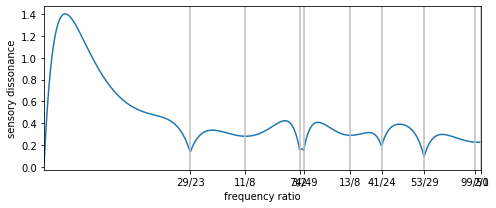

[1.2608695652173914, 1.375, 1.5, 1.510204081632653, 1.625, 1.7083333333333333, 1.8275862068965518, 1.98, 2.0]
7
11
1
5
0
0
25
(array([261, 375, 500, 509, 623, 708, 827], dtype=int64),)


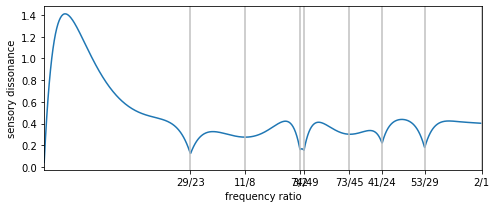

[1.2608695652173914, 1.375, 1.5, 1.510204081632653, 1.6222222222222222, 1.7083333333333333, 1.8275862068965518, 2.0]
7
11
1
10
0
0
17
(array([261, 379, 500, 641, 758], dtype=int64),)


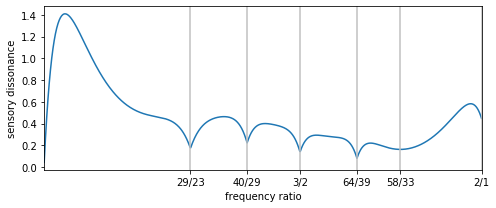

[1.2608695652173914, 1.3793103448275863, 1.5, 1.641025641025641, 1.7575757575757576, 2.0]
6
11
5
0
24
30
4
(array([226, 291, 442, 454, 655, 768, 878], dtype=int64),)


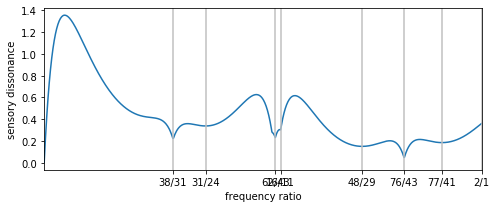

[1.2258064516129032, 1.2916666666666667, 1.441860465116279, 1.4545454545454546, 1.6551724137931034, 1.7674418604651163, 1.8780487804878048, 2.0]
6
11
1
0
38
17
4
(array([161, 261, 343, 452, 559, 655, 846], dtype=int64),)


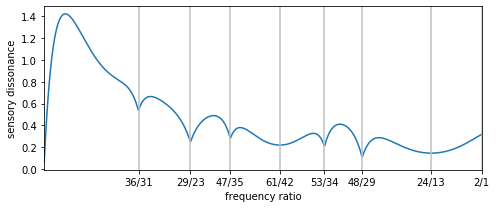

[1.1612903225806452, 1.2608695652173914, 1.3428571428571427, 1.4523809523809523, 1.5588235294117647, 1.6551724137931034, 1.8461538461538463, 2.0]
6
11
1
0
38
17
44
(array([161, 261, 454, 635, 654, 794, 897], dtype=int64),)


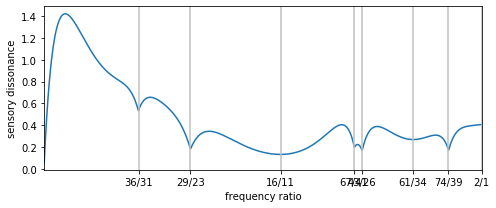

[1.1612903225806452, 1.2608695652173914, 1.4545454545454546, 1.6341463414634145, 1.6538461538461537, 1.7941176470588236, 1.8974358974358974, 2.0]
6
11
1
0
0
0
25
(array([261, 396, 499, 655, 666, 708, 885], dtype=int64),)


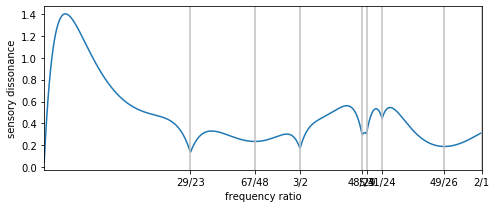

[1.2608695652173914, 1.3958333333333333, 1.5, 1.6551724137931034, 1.6666666666666667, 1.7083333333333333, 1.8846153846153846, 2.0]
6
11
1
5
0
0
25
(array([261, 376, 500, 509, 626, 708, 827, 989], dtype=int64),)


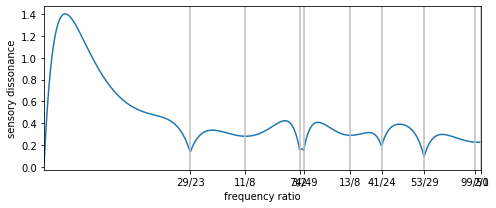

[1.2608695652173914, 1.375, 1.5, 1.510204081632653, 1.625, 1.7083333333333333, 1.8275862068965518, 1.98, 2.0]
7
11
1
5
0
0
25
(array([261, 375, 500, 509, 623, 708, 827], dtype=int64),)


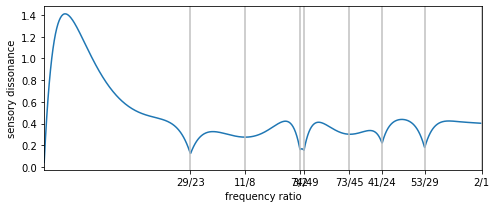

[1.2608695652173914, 1.375, 1.5, 1.510204081632653, 1.6222222222222222, 1.7083333333333333, 1.8275862068965518, 2.0]
6
11
14
0
9
18
4
(array([143, 279, 333, 438, 550, 643, 825, 853], dtype=int64),)


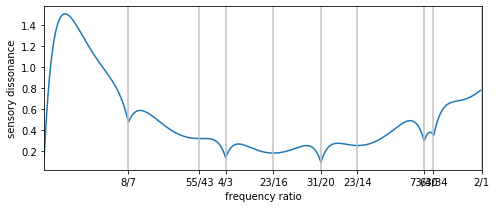

[1.1428571428571428, 1.2790697674418605, 1.3333333333333333, 1.4375, 1.55, 1.6428571428571428, 1.825, 1.8529411764705883, 2.0]
6
11
1
0
38
0
25
(array([261, 461, 654, 708, 737, 895], dtype=int64),)


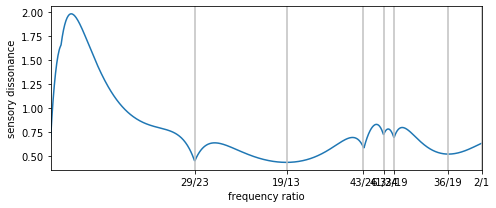

[1.2608695652173914, 1.4615384615384615, 1.6538461538461537, 1.7083333333333333, 1.736842105263158, 1.894736842105263, 2.0]
1
11
1
0
38
0
26
(array([261, 476, 654, 716, 745, 915], dtype=int64),)


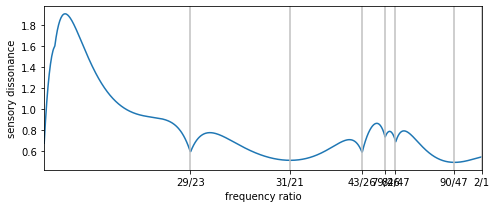

[1.2608695652173914, 1.4761904761904763, 1.6538461538461537, 1.7173913043478262, 1.7446808510638299, 1.9148936170212767, 2.0]
6
11
1
25
0
17
25
(array([ 96, 261, 409, 496, 597, 712, 876], dtype=int64),)


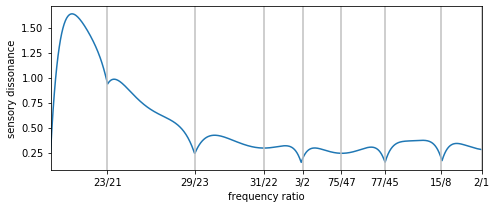

[1.0952380952380953, 1.2608695652173914, 1.4090909090909092, 1.5, 1.5957446808510638, 1.711111111111111, 1.875, 2.0]
7
11
1
5
0
0
32
(array([261, 375, 500, 509, 638, 766, 827], dtype=int64),)


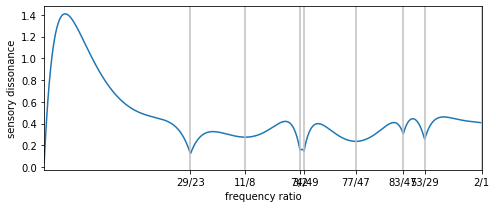

[1.2608695652173914, 1.375, 1.5, 1.510204081632653, 1.6382978723404256, 1.7659574468085106, 1.8275862068965518, 2.0]
1
11
5
8
39
4
27
(array([ 42, 275, 434, 536, 669, 696, 739, 933], dtype=int64),)


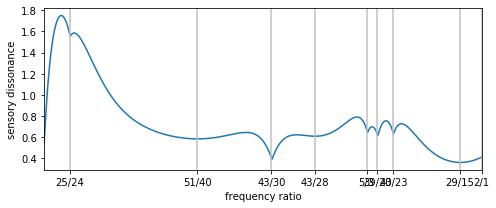

[1.0416666666666667, 1.275, 1.4333333333333333, 1.5357142857142858, 1.6666666666666667, 1.6956521739130435, 1.7391304347826086, 1.9333333333333333, 2.0]
2
11
1
15
39
4
27
(array([ 42, 261, 514, 669, 739, 888, 967], dtype=int64),)


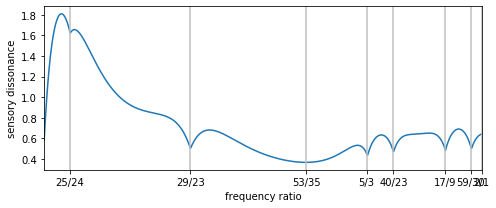

[1.0416666666666667, 1.2608695652173914, 1.5142857142857142, 1.6666666666666667, 1.7391304347826086, 1.8888888888888888, 1.9666666666666666, 2.0]
2
11
1
0
25
4
27
(array([181, 261, 470, 655, 668, 831, 970], dtype=int64),)


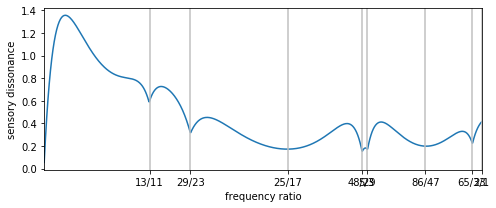

[1.1818181818181819, 1.2608695652173914, 1.4705882352941178, 1.6551724137931034, 1.6666666666666667, 1.8297872340425532, 1.9696969696969697, 2.0]
7
11
1
4
0
34
27
(array([261, 344, 450, 538, 643, 792, 924], dtype=int64),)


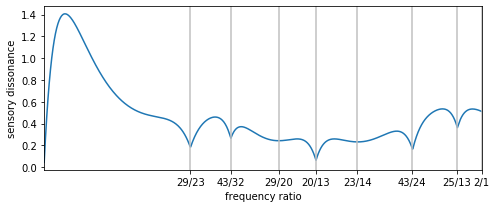

[1.2608695652173914, 1.34375, 1.45, 1.5384615384615385, 1.6428571428571428, 1.7916666666666667, 1.9230769230769231, 2.0]
7
1
1
22
0
0
42
(array([143, 182, 399, 500, 605, 714, 849, 988], dtype=int64),)


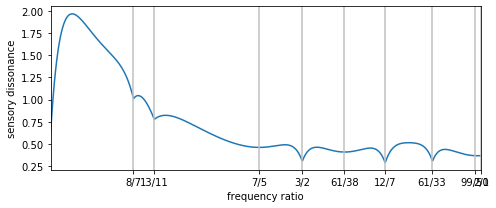

[1.1428571428571428, 1.1818181818181819, 1.4, 1.5, 1.605263157894737, 1.7142857142857142, 1.8484848484848484, 1.98, 2.0]
7
11
0
15
0
21
42
(array([217, 270, 450, 574, 654, 762, 875], dtype=int64),)


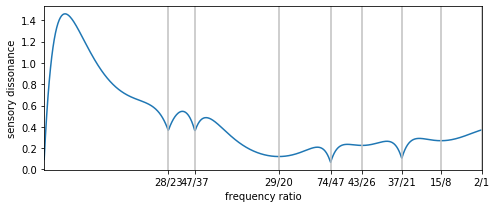

[1.2173913043478262, 1.2702702702702702, 1.45, 1.574468085106383, 1.6538461538461537, 1.7619047619047619, 1.875, 2.0]
1
2
13
15
0
0
42
(array([196, 270, 381, 500, 536, 698, 849, 904, 950], dtype=int64),)


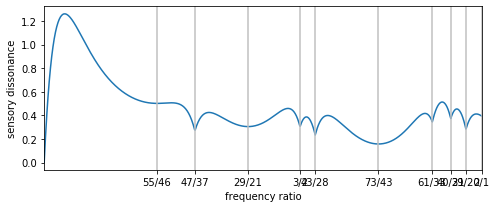

[1.1956521739130435, 1.2702702702702702, 1.380952380952381, 1.5, 1.5357142857142858, 1.697674418604651, 1.8484848484848484, 1.9047619047619047, 1.95, 2.0]
2
11
0
8
39
14
6
(array([126, 217, 388, 487, 562, 740], dtype=int64),)


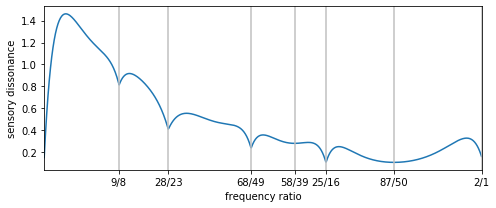

[1.125, 1.2173913043478262, 1.3877551020408163, 1.4871794871794872, 1.5625, 1.74, 2.0]
1
1
5
22
39
4
3
(array([ 42, 350, 475, 537, 613, 699, 771, 924], dtype=int64),)


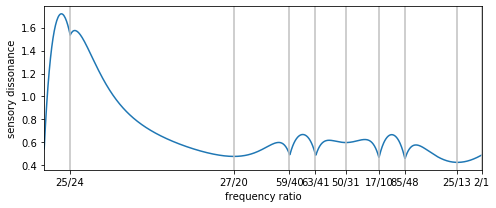

[1.0416666666666667, 1.35, 1.475, 1.5365853658536586, 1.6129032258064515, 1.7, 1.7708333333333333, 1.9230769230769231, 2.0]
7
1
1
0
25
4
27
(array([181, 461, 655, 668, 839, 970], dtype=int64),)


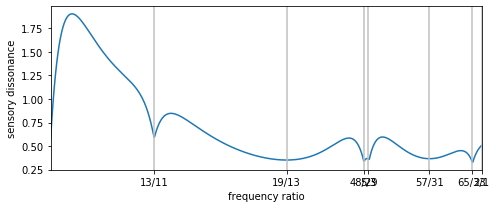

[1.1818181818181819, 1.4615384615384615, 1.6551724137931034, 1.6666666666666667, 1.8387096774193548, 1.9696969696969697, 2.0]
7
1
1
22
1
10
27
(array([157, 182, 443, 592, 604, 742, 856], dtype=int64),)


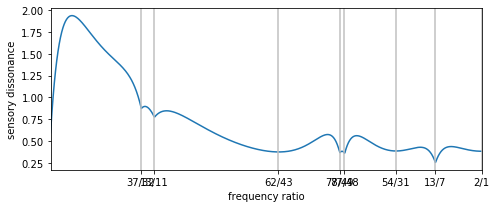

[1.15625, 1.1818181818181819, 1.441860465116279, 1.5918367346938775, 1.6041666666666667, 1.7419354838709677, 1.8571428571428572, 2.0]
7
1
14
15
0
21
42
(array([182, 270, 401, 499, 574, 678, 762, 904], dtype=int64),)


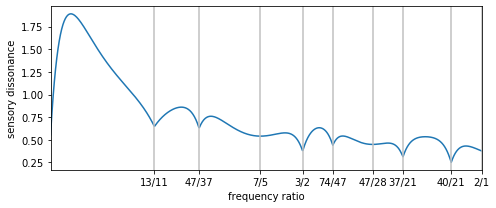

[1.1818181818181819, 1.2702702702702702, 1.4, 1.5, 1.574468085106383, 1.6785714285714286, 1.7619047619047619, 1.9047619047619047, 2.0]
0
1
0
15
0
20
42
(array([193, 270, 461, 585, 671, 749, 893], dtype=int64),)


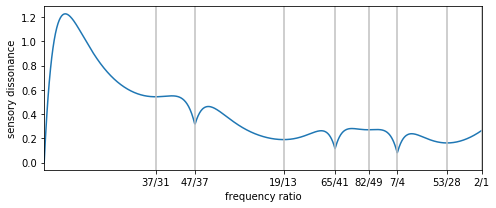

[1.1935483870967742, 1.2702702702702702, 1.4615384615384615, 1.5853658536585367, 1.6734693877551021, 1.75, 1.8928571428571428, 2.0]
3
11
0
3
1
14
14
(array([217, 366, 447, 588, 654, 821], dtype=int64),)


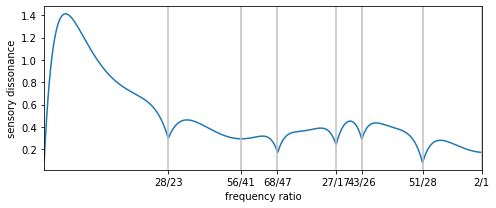

[1.2173913043478262, 1.3658536585365855, 1.446808510638298, 1.588235294117647, 1.6538461538461537, 1.8214285714285714, 2.0]
1
1
5
5
25
33
14
(array([207, 268, 368, 457, 605, 736, 847, 980], dtype=int64),)


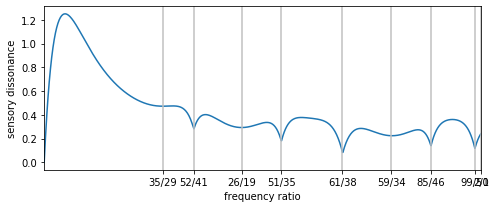

[1.206896551724138, 1.2682926829268293, 1.368421052631579, 1.457142857142857, 1.605263157894737, 1.7352941176470589, 1.8478260869565217, 1.98, 2.0]
7
1
7
5
25
4
55
(array([181, 391, 514, 721, 894, 980], dtype=int64),)


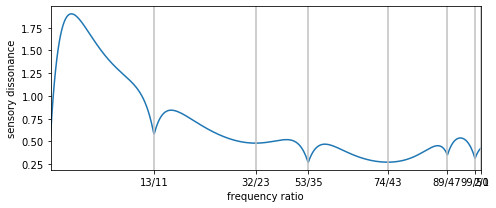

[1.1818181818181819, 1.391304347826087, 1.5142857142857142, 1.7209302325581395, 1.8936170212765957, 1.98, 2.0]
7
1
0
11
1
14
25
(array([182, 373, 529, 654, 814], dtype=int64),)


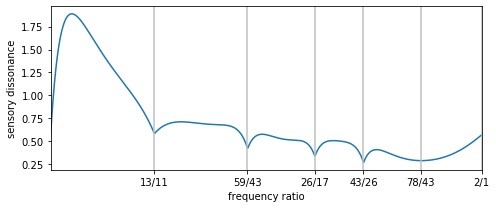

[1.1818181818181819, 1.372093023255814, 1.5294117647058822, 1.6538461538461537, 1.813953488372093, 2.0]
3
1
0
15
13
20
31
(array([315, 476, 505, 683, 856], dtype=int64),)


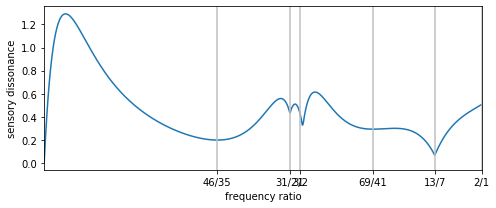

[1.3142857142857143, 1.4761904761904763, 1.5, 1.6829268292682926, 1.8571428571428572, 2.0]
3
11
0
15
13
31
31
(array([217, 327, 397, 476, 623, 876], dtype=int64),)


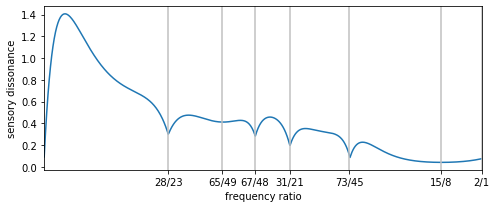

[1.2173913043478262, 1.3265306122448979, 1.3958333333333333, 1.4761904761904763, 1.6222222222222222, 1.875, 2.0]
7
1
5
0
25
33
14
(array([182, 268, 355, 456, 685, 847, 997], dtype=int64),)


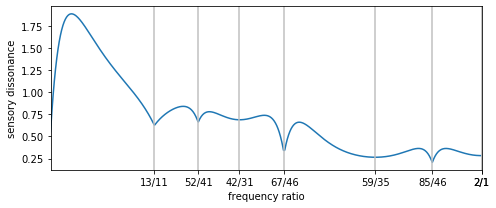

[1.1818181818181819, 1.2682926829268293, 1.3548387096774193, 1.4565217391304348, 1.6857142857142857, 1.8478260869565217, 2.0, 2.0]
7
1
0
15
22
33
14
(array([182, 268, 406, 499, 618, 759, 901], dtype=int64),)


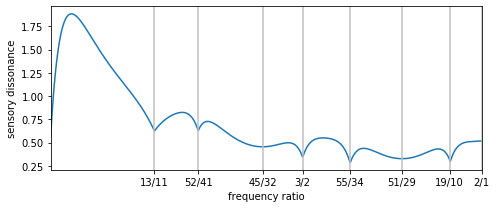

[1.1818181818181819, 1.2682926829268293, 1.40625, 1.5, 1.6176470588235294, 1.7586206896551724, 1.9, 2.0]
1
1
0
11
13
55
32
(array([211, 420, 576, 723, 881], dtype=int64),)


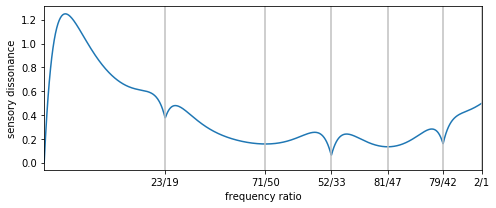

[1.2105263157894737, 1.42, 1.5757575757575757, 1.7234042553191489, 1.880952380952381, 2.0]
3
1
0
15
21
55
40
(array([257, 415, 603, 732, 856], dtype=int64),)


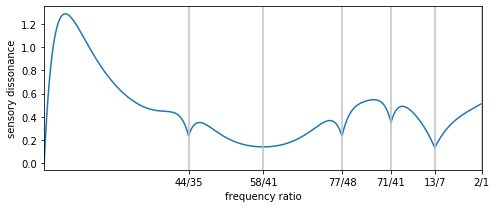

[1.2571428571428571, 1.4146341463414633, 1.6041666666666667, 1.7317073170731707, 1.8571428571428572, 2.0]


In [910]:
epochs_crop = epochs_temp.crop(0.5, 7.5)
eeg_data = epochs_crop.get_data()
eeg_data.shape


#for trial in range(11):
eeg_trial = eeg_data[34, :, :]
peaks_tot = []
amps_tot = []
print(eeg_trial.shape)
for ch in range(len(eeg_trial)):
    eeg_temp = eeg_trial[ch, :]
    peaks_raw, amps = compute_peaks_raw(eeg_temp, FREQ_BANDS)
    peaks_int = [int(np.round(p*128)) for p in peaks_raw]
    amps = [(float(i)-min(amp))/(max(amp)-min(amp)) for i in amp]
    amps = np.interp(amp, (amp.min(), amp.max()), (0.4, 0.6))

    intervals, ratios = diss_curve(peaks_int, amps, 50, 2)
    create_SCL(ratios, 'diss_curve_'+str(ch))
    print(ratios)

Applying baseline correction (mode: mean)
(104, 114, 9501)
Effective window size : 4.000 (s)
0
Effective window size : 4.000 (s)
6
Effective window size : 4.000 (s)
7
Effective window size : 4.000 (s)
28
Effective window size : 4.000 (s)
0
Effective window size : 4.000 (s)
20
Effective window size : 4.000 (s)
22
(array([ 53, 329, 442, 588, 749, 841, 954], dtype=int64),)


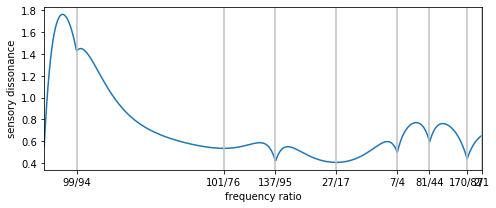

[1.053191489361702,
 1.3289473684210527,
 1.4421052631578948,
 1.588235294117647,
 1.75,
 1.8409090909090908,
 1.9540229885057472,
 2.0]

In [908]:
#E55
condition = par
chs = 'E88'
peaks, amp = compute_peaks_avg(epochs, condition, chs, FREQ_BANDS, dim_reduc = 'avg', 
                          tmin = None, tmax = None, precision = 0.25, sf = 1000)
peaks_int = [int(np.round(p*128)) for p in peaks]
amps = [(float(i)-min(amp))/(max(amp)-min(amp)) for i in amp]
amps = np.interp(amp, (amp.min(), amp.max()), (0.4, 0.6))

intervals, ratios = diss_curve(peaks_int, amps, 100, 2)
ratios

In [906]:
ratios

[1.0526315789473684,
 1.263157894736842,
 1.4444444444444444,
 1.5714285714285714,
 1.625,
 1.65,
 2.0]

In [894]:
intervals[0][0]/intervals[0][0]

10

In [909]:
create_SCL(ratios, 'test_diss_scale')

In [251]:
### 
#E55
channels = ['E95', 'E96', 'E97', 'E98']
condition = par
peaks_tot = []
amps_tot = []
for ch in channels:
    
    condition = nopar
    chs = ch
    peaks, amp = compute_peaks_avg(epochs, condition, ch, FREQ_BANDS, dim_reduc = 'avg', 
                              tmin = None, tmax = None, precision = 0.125, sf = 1000)
    peaks_tot.append([int(np.round(p*128)) for p in peaks])
    amps = [(float(i)-min(amp))/(max(amp)-min(amp)) for i in amp]
    amps = np.interp(amp, (amp.min(), amp.max()), (0.4, 0.6))
    amps_tot.append(amps)
    




Applying baseline correction (mode: mean)
(104, 114, 9501)
Effective window size : 8.000 (s)
3
Effective window size : 8.000 (s)
26
Effective window size : 8.000 (s)
12
Effective window size : 8.000 (s)
33
Effective window size : 8.000 (s)
26
Effective window size : 8.000 (s)
1
Effective window size : 8.000 (s)
87
Applying baseline correction (mode: mean)
(104, 114, 9501)
Effective window size : 8.000 (s)
3
Effective window size : 8.000 (s)
26
Effective window size : 8.000 (s)
12
Effective window size : 8.000 (s)
5
Effective window size : 8.000 (s)
26
Effective window size : 8.000 (s)
37
Effective window size : 8.000 (s)
12
Applying baseline correction (mode: mean)
(104, 114, 9501)
Effective window size : 8.000 (s)
3
Effective window size : 8.000 (s)
26
Effective window size : 8.000 (s)
12
Effective window size : 8.000 (s)
10
Effective window size : 8.000 (s)
26
Effective window size : 8.000 (s)
13
Effective window size : 8.000 (s)
7
Applying baseline correction (mode: mean)
(104, 114,

(array([194, 297, 370, 441, 639, 857, 869, 893], dtype=int64),)
(array([211, 344, 370, 482, 491, 682, 840], dtype=int64),)
(array([214, 362, 370, 452, 553, 680, 757, 863, 977], dtype=int64),)
(array([213, 344, 370, 441, 647, 852, 893], dtype=int64),)
[344.0, 370.0, 370.0, 370.0, 441.0, 893.0]
344.0
4/3
370.0
11/8
370.0
11/8
370.0
11/8
441.0
13/9
893.0
17/9
[(4, 3), (11, 8), (11, 8), (11, 8), (13, 9), (17, 9), (2, 1)]


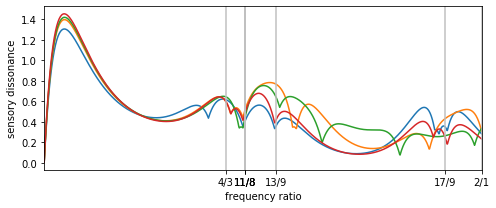

In [252]:
diss_tot = diss_curve_multi(peaks_tot, amps_tot, 10, 2, 1)

## Plot dissonance curve from EEG peak extraction

(array([195, 297, 370, 441, 640, 856, 869, 893], dtype=int64),)
(array([213, 344, 370, 482, 491, 686, 840], dtype=int64),)
(array([218, 362, 370, 452, 553, 757, 854, 977], dtype=int64),)
(array([216, 344, 370, 441, 647, 852, 893], dtype=int64),)
[344.0, 370.0, 370.0, 370.0, 441.0, 893.0]
344.0
125/93
370.0
137/100
370.0
137/100
370.0
137/100
441.0
134/93
893.0
53/28
[(125, 93), (137, 100), (137, 100), (137, 100), (134, 93), (53, 28), (2, 1)]


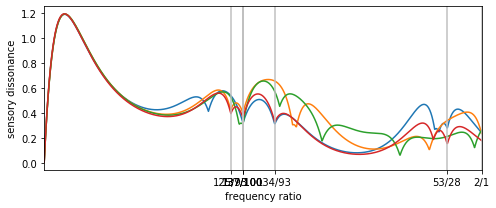

In [75]:
diss_tot = diss_curve_multi(peaks_tot, amps_tot, 100, 2, 0.0001)

In [355]:
flat_list = [item for sublist in diss_tot for item in sublist]
flat_list.sort()
flat_list
new_minima = []
bound = 5
for n in range(len(flat_list)-1):
    if flat_list[n+1] - flat_list[n] < bound:
        new_minima.append((flat_list[n]+flat_list[n+1])/2)
        
new_minima

[320.5, 517.0]

In [380]:
frac = Fraction(320.5/(1000/(2-1))+1).limit_denominator(10)
frac

Fraction(4, 3)

In [292]:
def diss_curve_multi (freqs, amps, denom=10, max_ratio=2, bound = 10):
    from numpy import array, linspace, empty, concatenate
    from scipy.signal import argrelextrema
    from fractions import Fraction
    plt.figure(figsize=(18, 8))
    diss_minima_tot = []
    for fr, am in zip(freqs, amps):
        freqs = np.array(fr)
        r_low = 1
        alpharange = max_ratio
        method = 'product'

        n = 1000
        diss = empty(n)
        a = concatenate((am, am))
        for i, alpha in enumerate(linspace(r_low, alpharange, n)):
            f = concatenate((freqs, alpha*freqs))
            d = dissmeasure(f, a, method)
            diss[i] = d

        
        plt.plot(linspace(r_low, alpharange, len(diss)), diss)
        plt.xscale('log')
        plt.xlim(r_low, alpharange)

        plt.xlabel('frequency ratio')
        plt.ylabel('sensory dissonance')


        diss_minima = argrelextrema(diss, np.less)
        diss_minima_tot.append(list(diss_minima[0]))
        print(diss_minima)
    
    diss_tot = [item for sublist in diss_minima_tot for item in sublist]
    diss_tot.sort()
    new_minima = []
    
    for i in range(len(diss_tot)-1):
        if (diss_tot[i+1] - diss_tot[i]) < bound:
            new_minima.append((diss_tot[i]+diss_tot[i+1])/2)
    print(new_minima)
    intervals = []
    for d in range(len(new_minima)):
        print(new_minima[d])
        frac = Fraction(new_minima[d]/(n/(max_ratio-1))+1).limit_denominator(denom)
        print(frac)
        frac = (frac.numerator, frac.denominator)
        intervals.append(frac)
    
    #intervals = [(123, 100), (147, 100), (159, 100), (9, 5), (2, 1)]
    intervals.append((2, 1))
    print(intervals)
    for n, d in intervals:
        plt.axvline(n/d, color='silver')

    #plt.yticks([])
    plt.minorticks_off()
    plt.xticks([n/d for n, d in intervals],
               ['{}/{}'.format(n, d) for n, d in intervals])
    plt.tight_layout()
    plt.show()
    return diss_minima_tot

## PyGame

In [525]:
import pygame, pygame.sndarray
import numpy as np
import scipy.signal

sample_rate = 44100
pygame.init()
pygame.mixer.init(frequency=44100, size=-16, channels=2, buffer=512)
    
def sine_wave(hz, peak, n_samples=sample_rate):
    """Compute N samples of a sine wave with given frequency and peak amplitude.
       Defaults to one second.
    """
    length = sample_rate / float(hz)
    omega = numpy.pi * 2 / length
    xvalues = numpy.arange(int(length)) * omega
    onecycle = peak * numpy.sin(xvalues)
    return numpy.resize(onecycle, (n_samples,)).astype(numpy.int16)

def square_wave(hz, peak, duty_cycle=.5, n_samples=sample_rate):
    """Compute N samples of a sine wave with given frequency and peak amplitude.
       Defaults to one second.
    """
    t = numpy.linspace(0, 1, 500 * 440/hz, endpoint=False)
    wave = scipy.signal.square(2 * numpy.pi * 5 * t, duty=duty_cycle)
    wave = numpy.resize(wave, (n_samples,))
    return (peak / 2 * wave.astype(numpy.int16))

waveform=sine_wave
def make_chord(hz, ratios):
    """Make a chord based on a list of frequency ratios."""
    sampling = 4096
    chord = waveform(hz, sampling)
    for r in ratios[1:]:
        chord = sum([chord, sine_wave(hz * r / ratios[0], sampling)])
    return chord

def major_triad(hz):
    return make_chord(hz, [4, 5, 6])

In [532]:
import numpy
length = 1000
chord = make_chord(400, [5, 6, 7])

chord = np.ascontiguousarray(np.vstack([chord,chord]).T)


sound = pygame.sndarray.make_sound(chord)
sound.play(loops=0, maxtime=0, fade_ms=0)
pygame.time.wait(int(sound.get_length() * length))

1001